In [ ]:
Data was collected to amount to a total of 100 unique gestures per twin, with 2 trials per gesture being used. 
The original data was made up of 19 columns, including time, and the number of rows per trial ranged from 56 to 150
    Preprocessing:
    -Data was resampled to the median length of collected data
    -Data was cascaded into two dfs, each (200, 2124) in shape
    -Data was normalized
    -Data was split 70/30 for training and testing purposes
Analysis:
    -A PCA process was run on each training df (2 processes total)
    -Resulting eigenvector/value calculations resulted in a cumulative variance of 12
    -Testing data was reconstructed based on the captured synergies via pseudo inverse function
    -Reconstructions were compared to the original using sum of squared difference(SSD) resulting in:
        -Abhay: SSD: 16847.2693, MSE (mean squared error): 0.132198
        -Arjun: SSD: 16287.7298, MSE (mean squared error): 0.127807

In [49]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

# === Config ===
expected_columns = [
    'time', 'palm_position_x', 'palm_position_y', 'palm_position_z',
    'palm_normal_x', 'palm_normal_y', 'palm_normal_z',
    'palm_direction_x', 'palm_direction_y', 'palm_direction_z',
    'hand_grab_angle', 'hand_grab_strength', 'hand_pinch_angle', 'hand_pinch_strength',
    'thumb_extension', 'index_extension', 'middle_extension', 'ring_extension', 'pinky_extension'
]
input_folder = r"C:\Users\Abhay\Downloads\ExportedSheets"

# === Utility Functions ===
def is_row_empty(row):
    return all(pd.isna(cell) or (isinstance(cell, str) and cell.strip() == '') for cell in row)

def trim_leading_empty_rows(df):
    for i in range(len(df)):
        if not is_row_empty(df.iloc[i]):
            return df.iloc[i:].reset_index(drop=True)
    return pd.DataFrame(columns=df.columns)

def trim_trailing_empty_rows(df):
    for i in reversed(range(len(df))):
        if not is_row_empty(df.iloc[i]):
            return df.iloc[:i+1].reset_index(drop=True)
    return pd.DataFrame(columns=df.columns)

def find_trial_split_index(df):
    for i in range(len(df)):
        if is_row_empty(df.iloc[i]):
            return i
    return None

def split_trials(df):
    df = trim_leading_empty_rows(df)
    split_idx = find_trial_split_index(df)
    if split_idx is None:
        return df.reset_index(drop=True), pd.DataFrame(columns=df.columns)
    trial1 = df.iloc[:split_idx]
    trial2 = df.iloc[split_idx+1:]
    trial1 = trim_trailing_empty_rows(trial1)
    trial2 = trim_leading_empty_rows(trial2)
    trial2 = trim_trailing_empty_rows(trial2)
    return trial1.reset_index(drop=True), trial2.reset_index(drop=True)

def resample_by_time(df, time_col, target_rows):
    df = df.copy()
    df[time_col] = pd.to_numeric(df[time_col], errors='coerce')
    df = df.dropna(subset=[time_col])
    df = df.drop_duplicates(subset=time_col)
    for col in df.columns:
        if col != time_col:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.set_index(time_col)
    new_time_index = np.linspace(df.index.min(), df.index.max(), target_rows)
    df_resampled = df.reindex(new_time_index)
    df_resampled = df_resampled.interpolate(method='linear', axis=0).reset_index()
    df_resampled.rename(columns={'index': time_col}, inplace=True)
    return df_resampled

def safe_resample(df_list, time_col, target_rows):
    return [
        resample_by_time(df, time_col, target_rows)
        for df in df_list
        if time_col in df.columns and not df.empty
    ]

def cascade_single_trial(df):
    df = df[[col for col in df.columns if not col.endswith("time")]]
    return pd.DataFrame([df.to_numpy().T.flatten()])

def get_k_components(pca, threshold=0.90):
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    k = np.argmax(cumulative_variance >= threshold) + 1
    return k

def reconstruct_from_pca(test_df, pca, k_components):
    eigenvectors_k = pca.components_[:k_components, :]
    projected = np.dot(test_df, eigenvectors_k.T)
    reconstructed = np.dot(projected, eigenvectors_k)
    return pd.DataFrame(reconstructed)

def compute_errors(original, reconstructed):
    original_np = original.to_numpy()
    reconstructed_np = reconstructed.to_numpy()
    ssd = np.sum((original_np - reconstructed_np) ** 2)
    mse = mean_squared_error(original_np, reconstructed_np)
    return ssd, mse


# === Load and Process All Files ===
csv_files = [f for f in os.listdir(input_folder) if f.endswith('.csv')]
abhay_trials, arjun_trials = [], []

for file in csv_files:
    path = os.path.join(input_folder, file)
    try:
        df = pd.read_csv(path, header=None)
        df = df.iloc[1:].reset_index(drop=True)
        df = df.iloc[:, :39]

        abhay_df = df.iloc[:, :19].copy()
        arjun_df = df.iloc[:, 20:].copy()

        abhay_df.columns = [f"Abhay_{col}" for col in expected_columns]
        arjun_df.columns = [f"Arjun_{col}" for col in expected_columns]

        abhay_df.dropna(axis=1, how='all', inplace=True)
        arjun_df.dropna(axis=1, how='all', inplace=True)

        abhay_t1, abhay_t2 = split_trials(abhay_df)
        arjun_t1, arjun_t2 = split_trials(arjun_df)

        abhay_trials.extend([abhay_t1, abhay_t2])
        arjun_trials.extend([arjun_t1, arjun_t2])
    except Exception as e:
        print(f"Error processing {file}: {e}")

# === Resample all trials ===
all_lengths = [len(df) for df in abhay_trials + arjun_trials]
median_len = int(np.median(all_lengths))
print(f"Using median trial length: {median_len}")

abhay_trials = safe_resample(abhay_trials, 'Abhay_time', median_len)
arjun_trials = safe_resample(arjun_trials, 'Arjun_time', median_len)

# === Cascade Each Trial Individually ===
cascaded_abhay = pd.concat([cascade_single_trial(trial) for trial in abhay_trials], ignore_index=True)
cascaded_arjun = pd.concat([cascade_single_trial(trial) for trial in arjun_trials], ignore_index=True)
print(f"Cascaded Abhay: {cascaded_abhay.shape}, Arjun: {cascaded_arjun.shape}")

# === Normalize and compute stats ===
scaler_abhay = MinMaxScaler()
normalized_abhay = pd.DataFrame(scaler_abhay.fit_transform(cascaded_abhay))
mean_abhay = cascaded_abhay.mean()
std_abhay = cascaded_abhay.std()
print("\n📈 Abhay Training Data Stats (Before Normalization):")
print(f"Mean:\n{mean_abhay.head()}\n")
print(f"Standard Deviation:\n{std_abhay.head()}")

scaler_arjun = MinMaxScaler()
normalized_arjun = pd.DataFrame(scaler_arjun.fit_transform(cascaded_arjun))
mean_arjun = cascaded_arjun.mean()
std_arjun = cascaded_arjun.std()
print("\n📈 Arjun Training Data Stats (Before Normalization):")
print(f"Mean:\n{mean_arjun.head()}\n")
print(f"Standard Deviation:\n{std_arjun.head()}")


# === Train/Test Split (70/30 per person) ===
train_abhay = normalized_abhay.iloc[:140].reset_index(drop=True)
test_abhay = normalized_abhay.iloc[140:].reset_index(drop=True)

train_arjun = normalized_arjun.iloc[:140].reset_index(drop=True)
test_arjun = normalized_arjun.iloc[140:].reset_index(drop=True)

# === PCA Training ===
pca_abhay = PCA().fit(train_abhay)
pca_arjun = PCA().fit(train_arjun)

# === Determine top-k for 90% variance ===
k_abhay = get_k_components(pca_abhay, threshold=0.90)
k_arjun = get_k_components(pca_arjun, threshold=0.90)
print(f"Abhay PCA components (90% var): {k_abhay}")
print(f"Arjun PCA components (90% var): {k_arjun}")

# === Reconstruct test data ===
reconstructed_abhay = reconstruct_from_pca(test_abhay, pca_abhay, k_abhay)
reconstructed_arjun = reconstruct_from_pca(test_arjun, pca_arjun, k_arjun)

# === Compute Errors ===
ssd_abhay, mse_abhay = compute_errors(test_abhay, reconstructed_abhay)
ssd_arjun, mse_arjun = compute_errors(test_arjun, reconstructed_arjun)

# === Print Final Output ===
print("\n✅ PCA & Reconstruction Complete")
print(f"Abhay: Test {test_abhay.shape} -> Reconstructed {reconstructed_abhay.shape}")
print(f"Arjun: Test {test_arjun.shape} -> Reconstructed {reconstructed_arjun.shape}")
print(f"\n📊 Abhay SSD: {ssd_abhay:.4f}, MSE: {mse_abhay:.6f}")
print(f"📊 Arjun SSD: {ssd_arjun:.4f}, MSE: {mse_arjun:.6f}")


Error processing abhay_training_stats.csv: Length mismatch: Expected axis has 3 elements, new values have 19 elements
Using median trial length: 118
Cascaded Abhay: (200, 2124), Arjun: (200, 2124)

📈 Abhay Training Data Stats (Before Normalization):
Mean:
0    8.265893
1    8.215061
2    8.164228
3    8.113395
4    8.062562
dtype: float64

Standard Deviation:
0    34.857958
1    34.752268
2    34.648751
3    34.547427
4    34.448314
dtype: float64

📈 Arjun Training Data Stats (Before Normalization):
Mean:
0    10.564059
1    10.455180
2    10.346301
3    10.237423
4    10.128544
dtype: float64

Standard Deviation:
0    30.352111
1    30.299992
2    30.251372
3    30.206268
4    30.164695
dtype: float64
Abhay PCA components (90% var): 12
Arjun PCA components (90% var): 12

✅ PCA & Reconstruction Complete
Abhay: Test (60, 2124) -> Reconstructed (60, 2124)
Arjun: Test (60, 2124) -> Reconstructed (60, 2124)

📊 Abhay SSD: 16847.2693, MSE: 0.132198
📊 Arjun SSD: 16287.7298, MSE: 0.127807


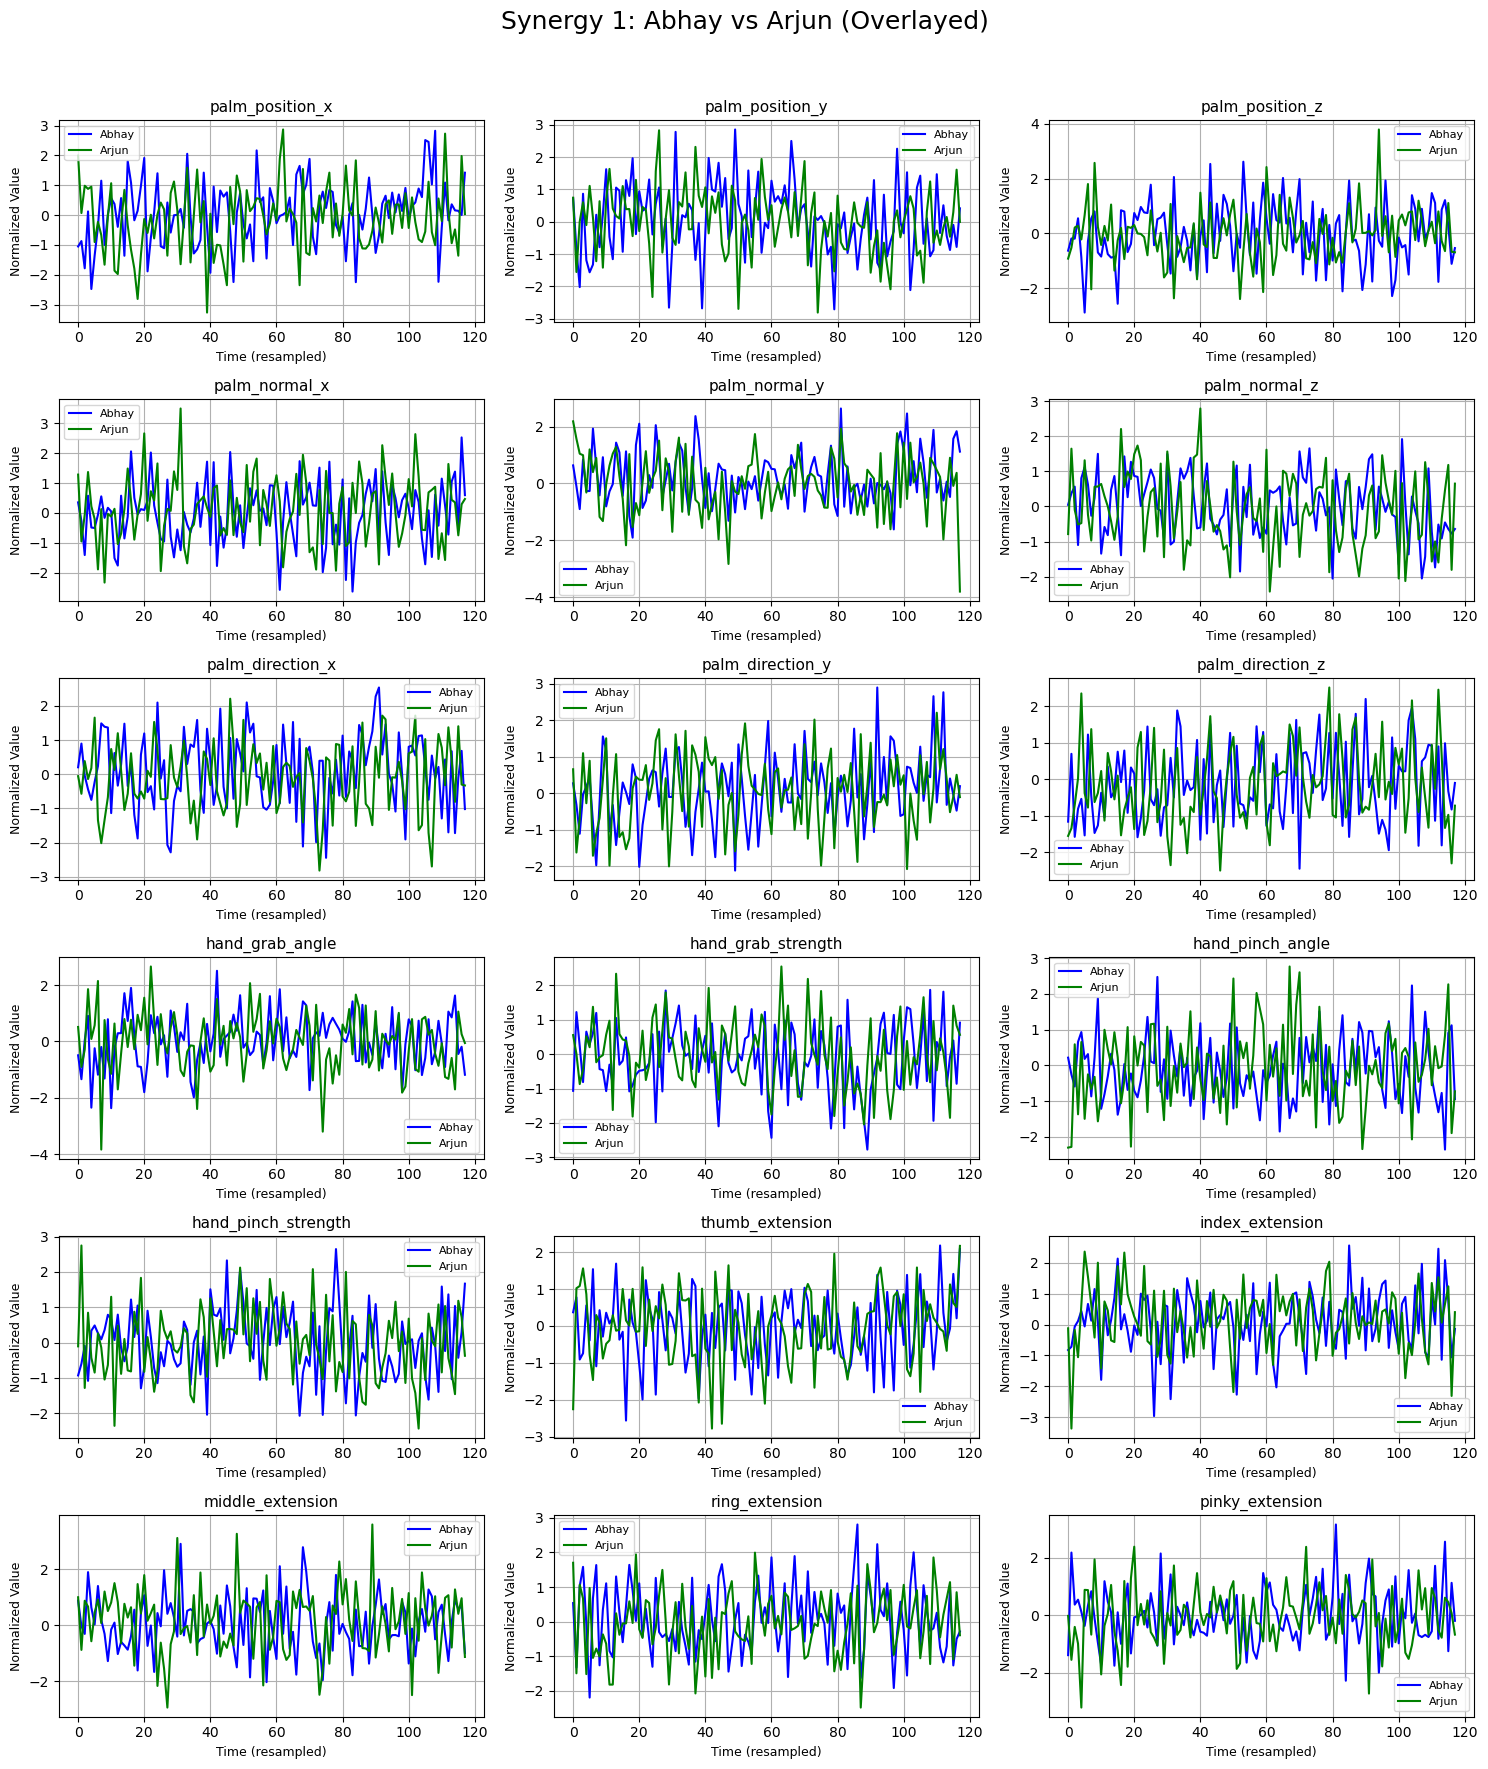

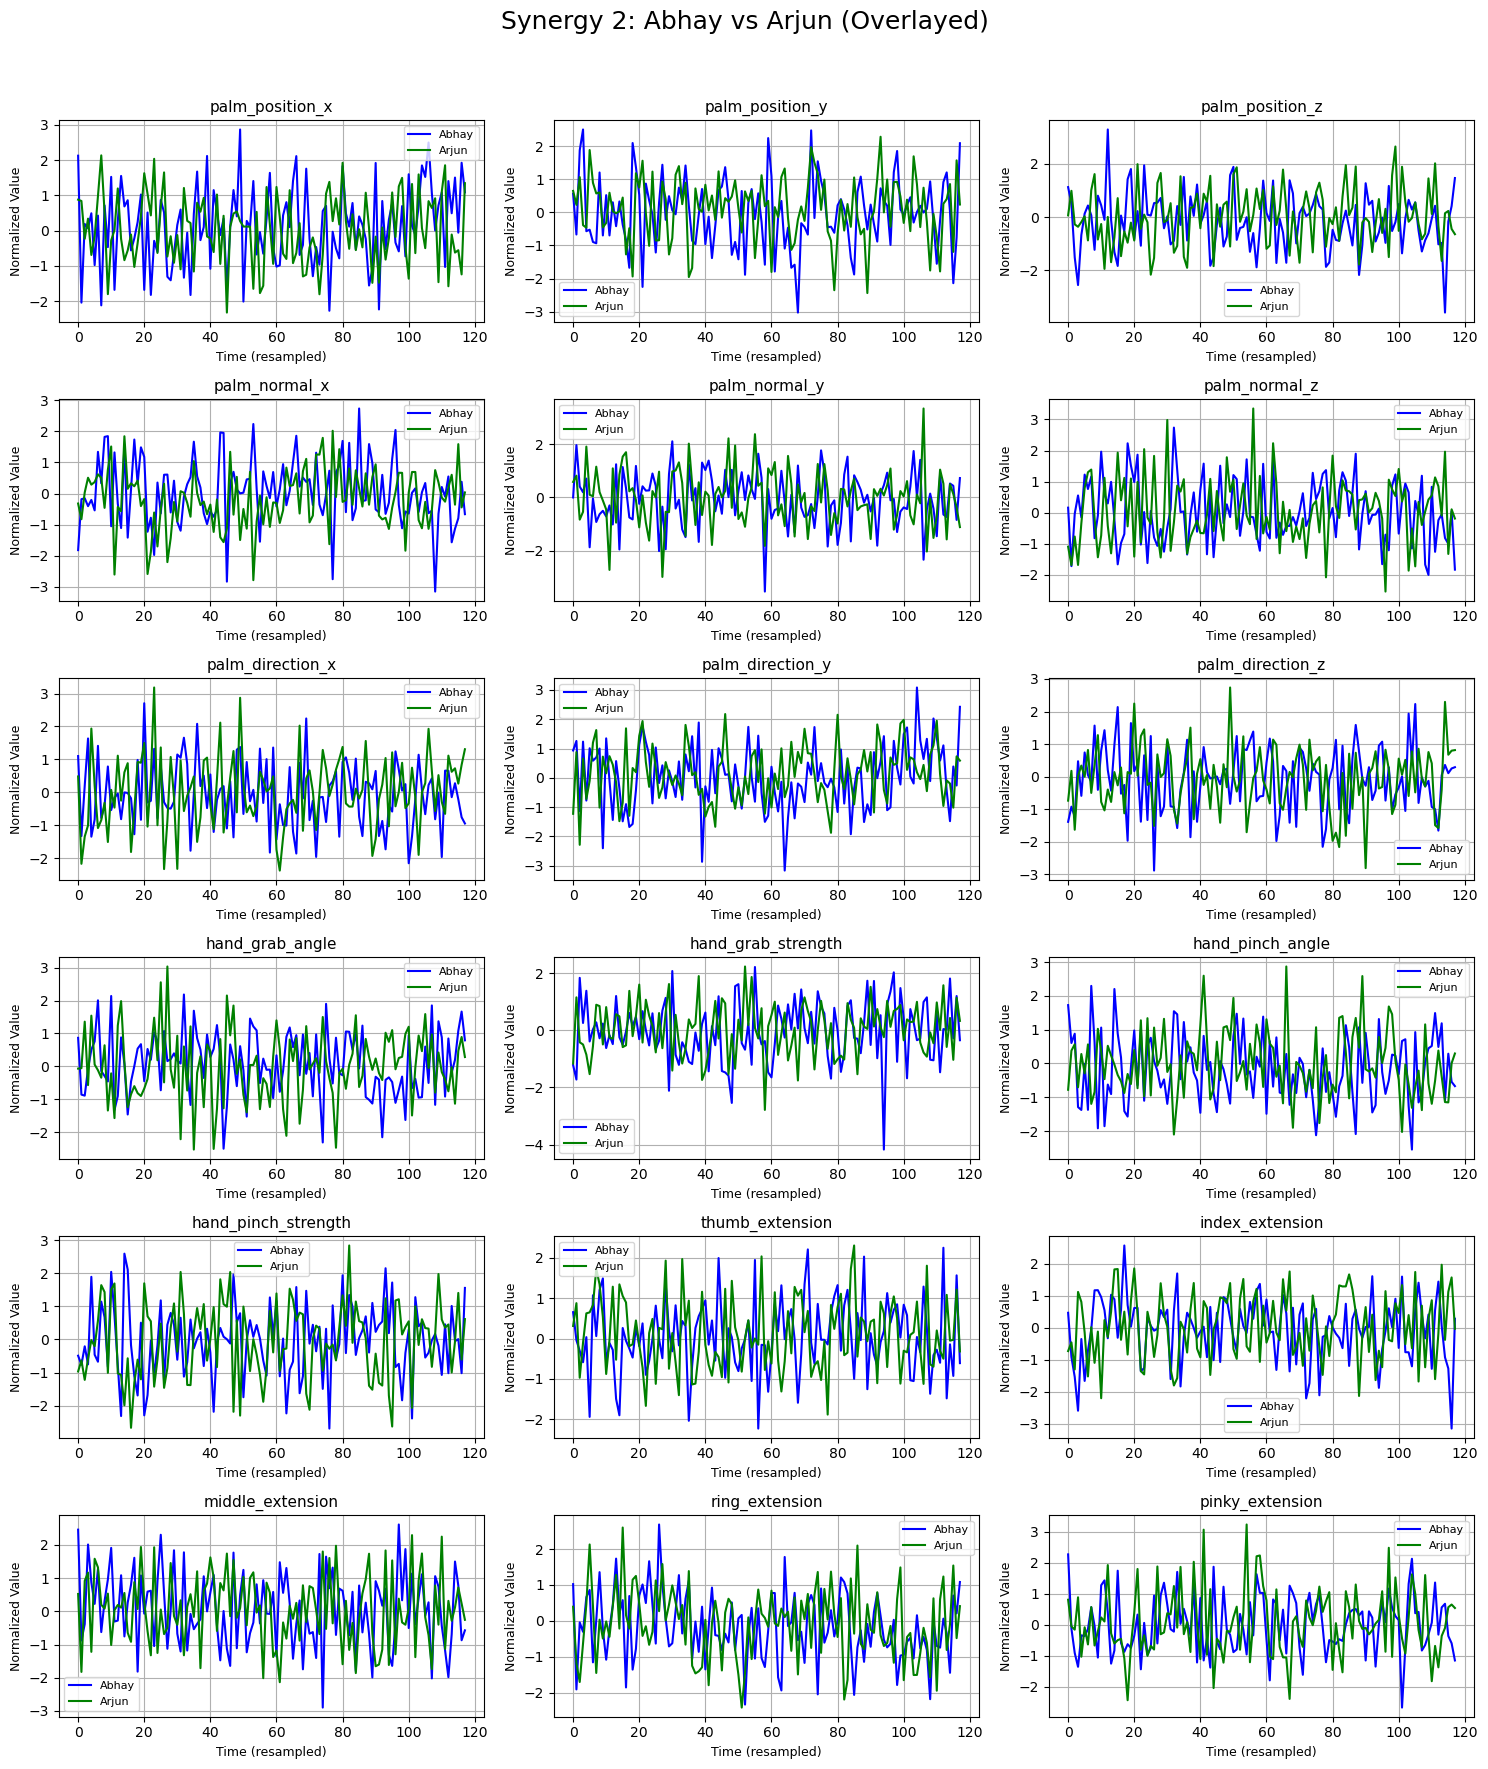

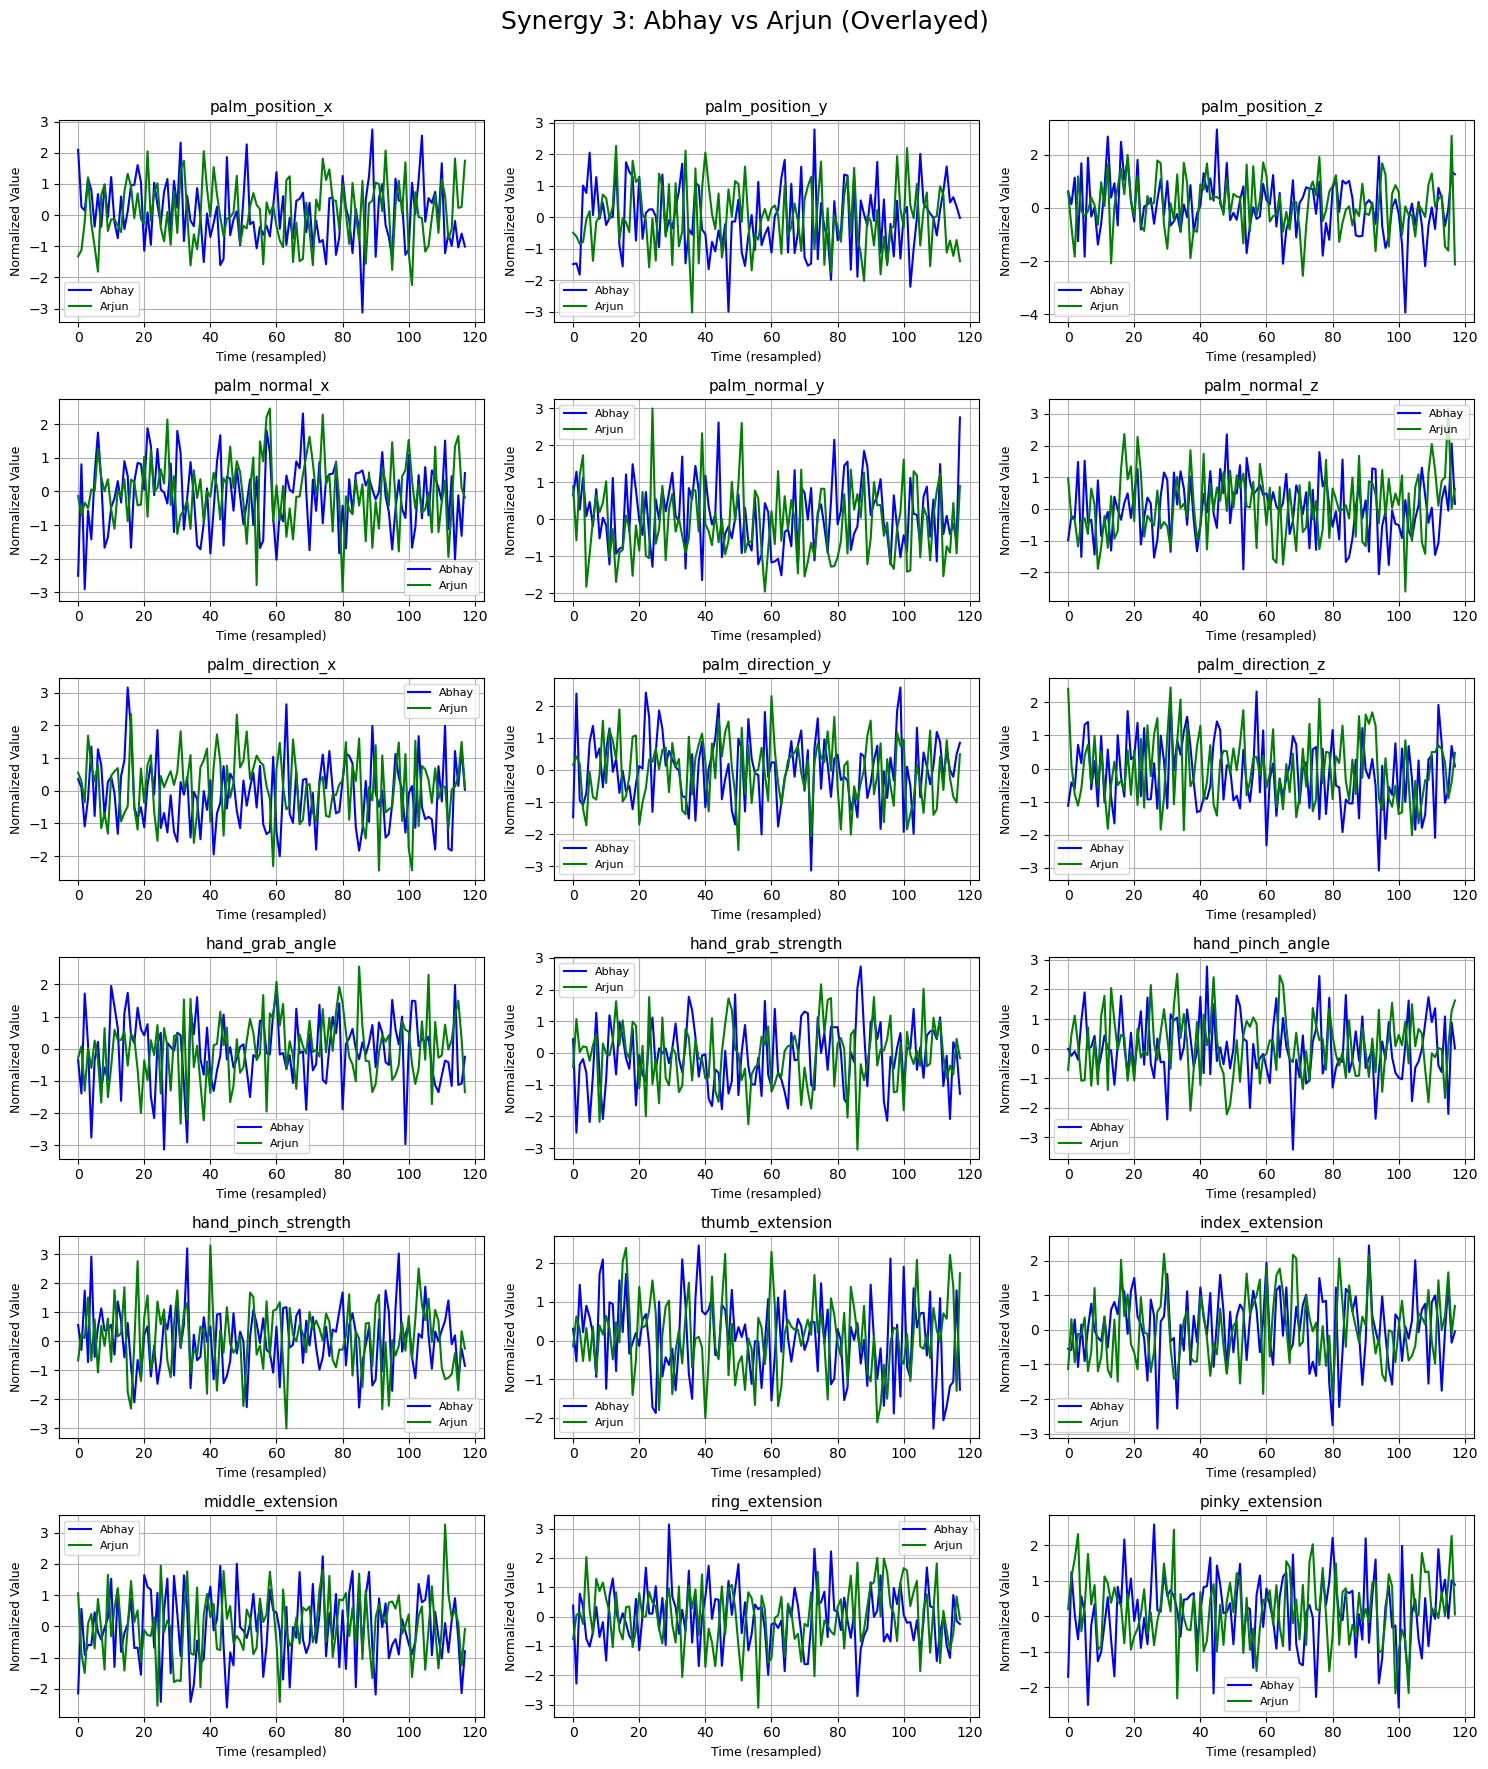

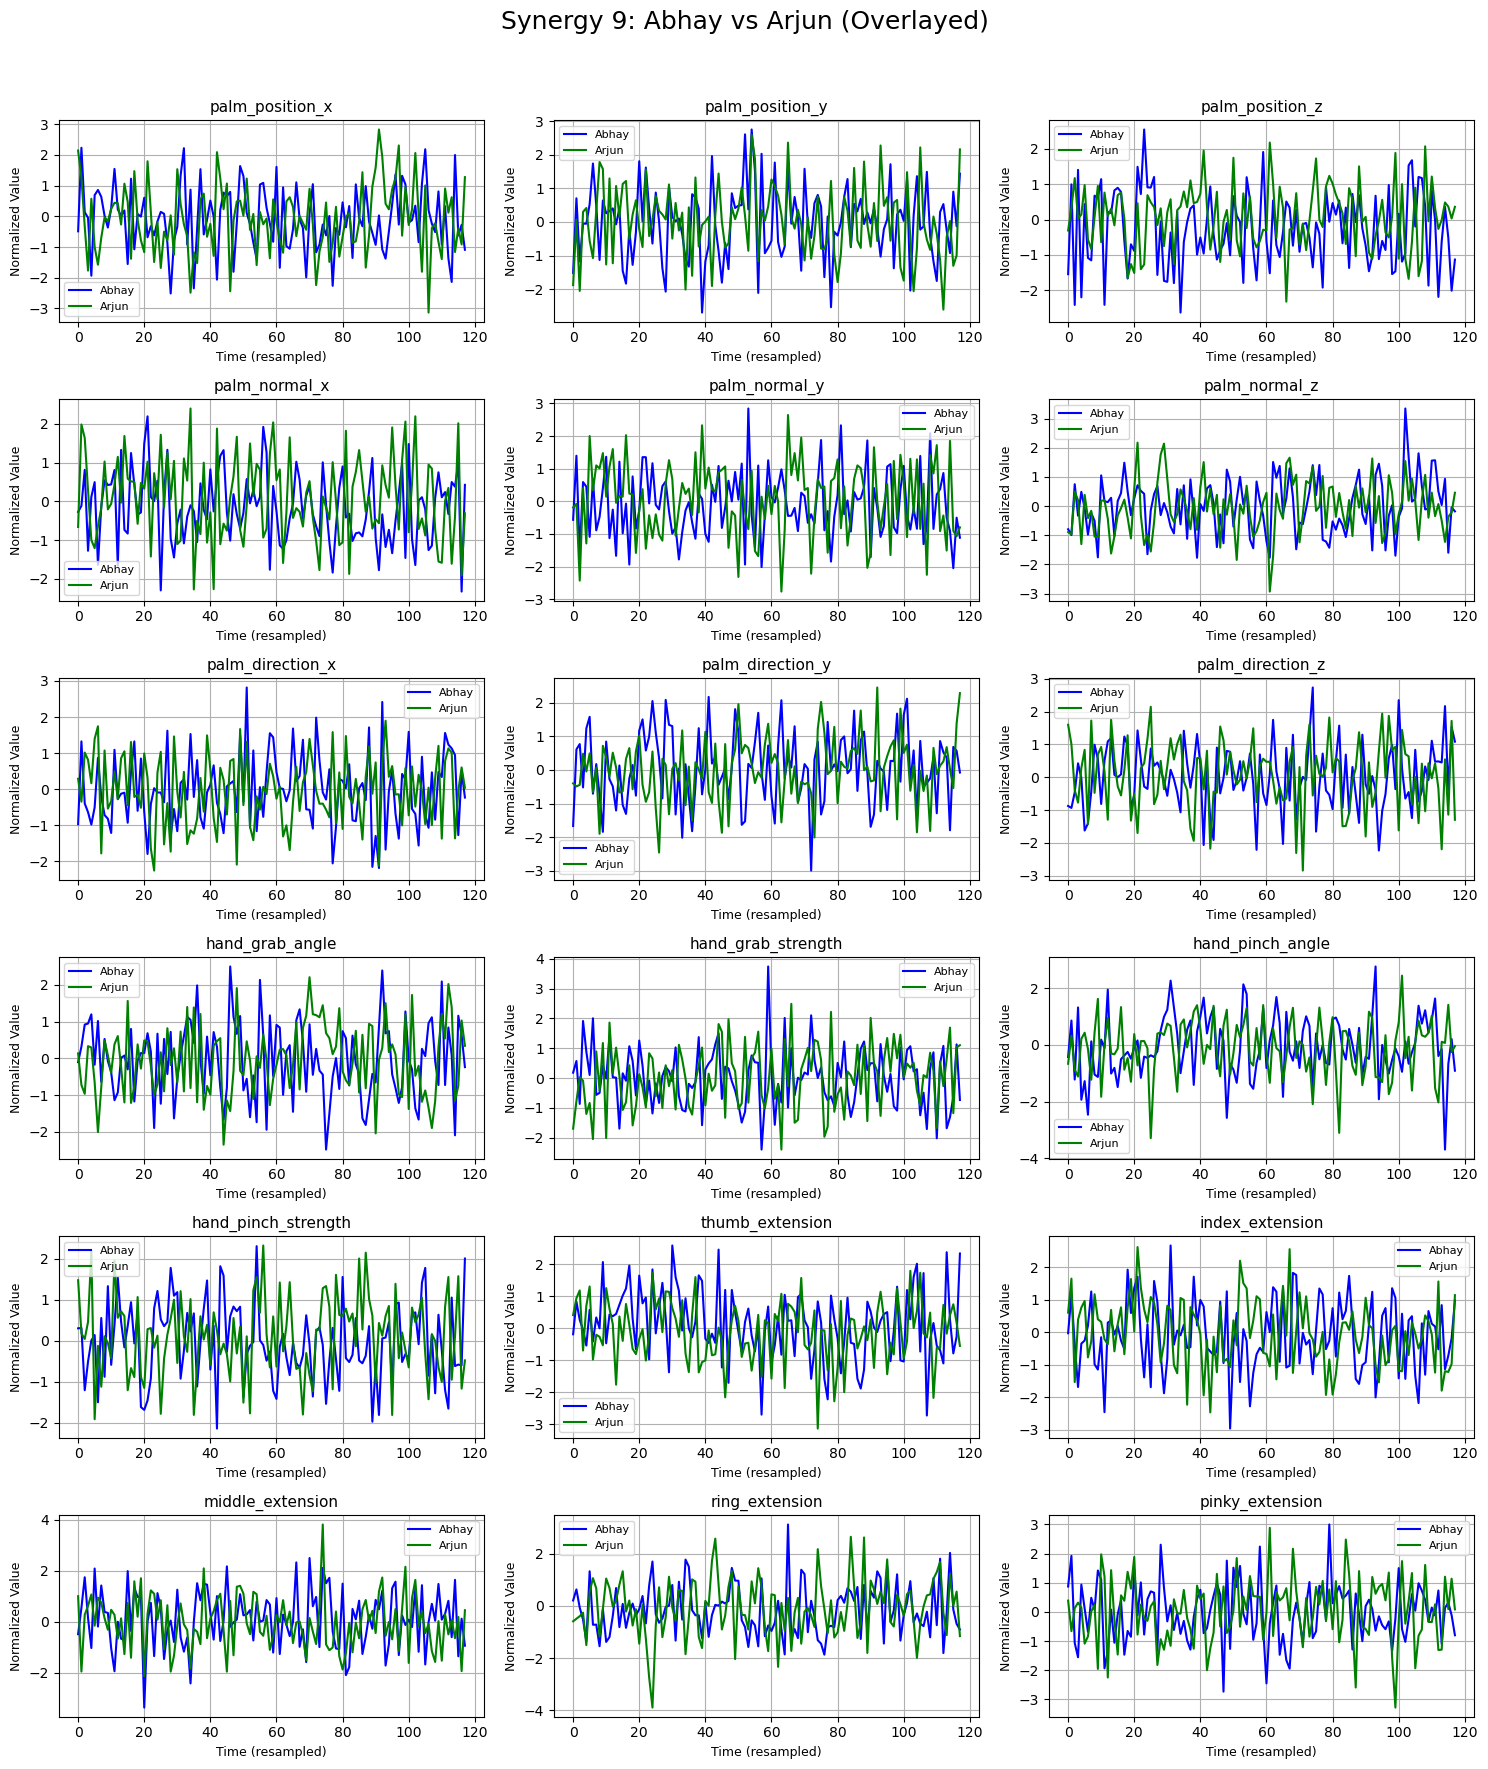

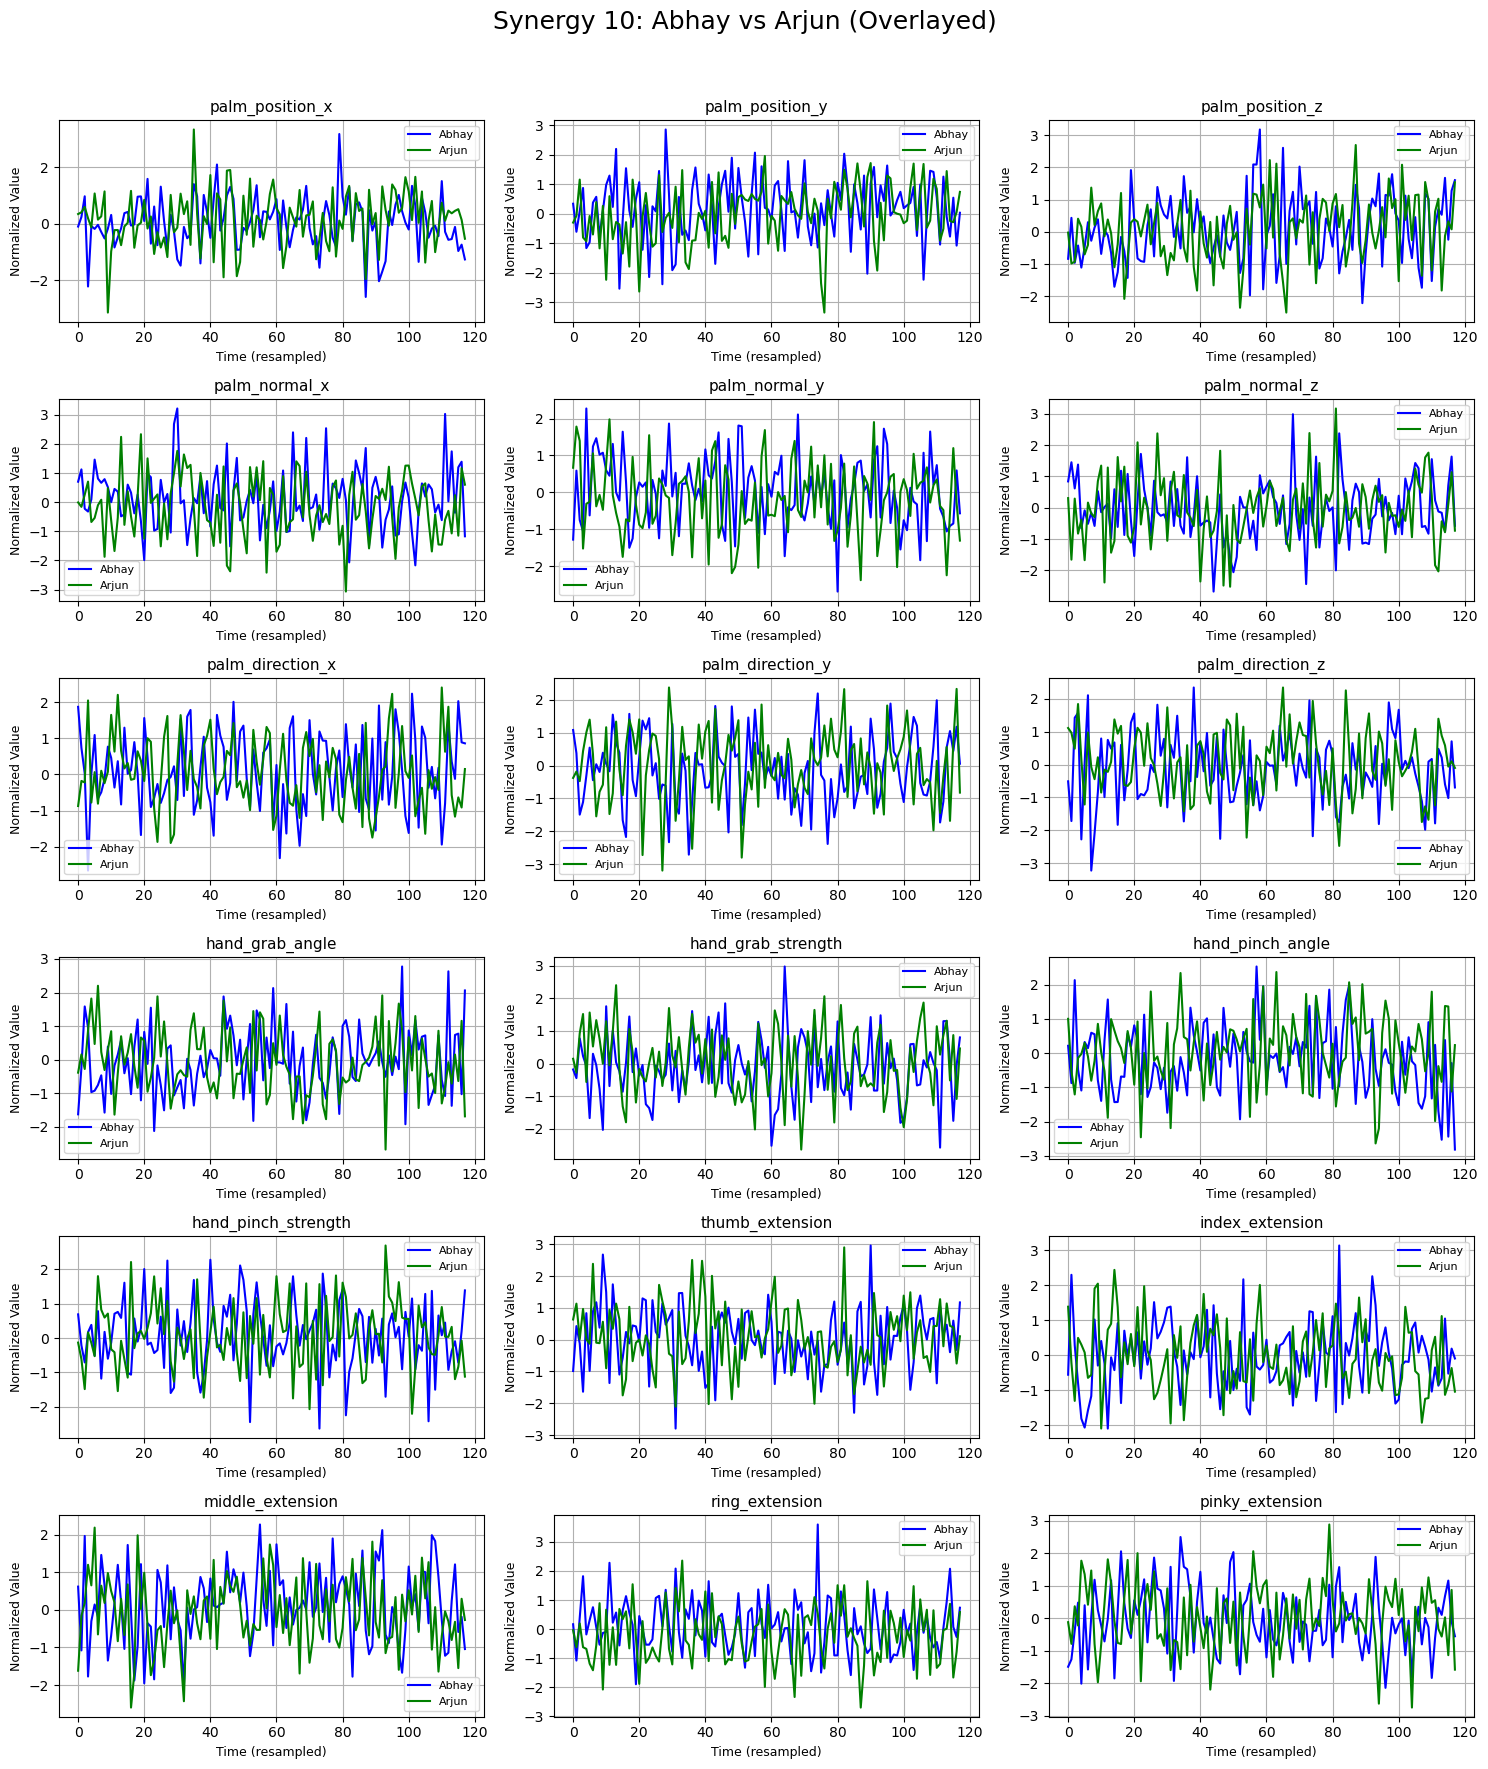

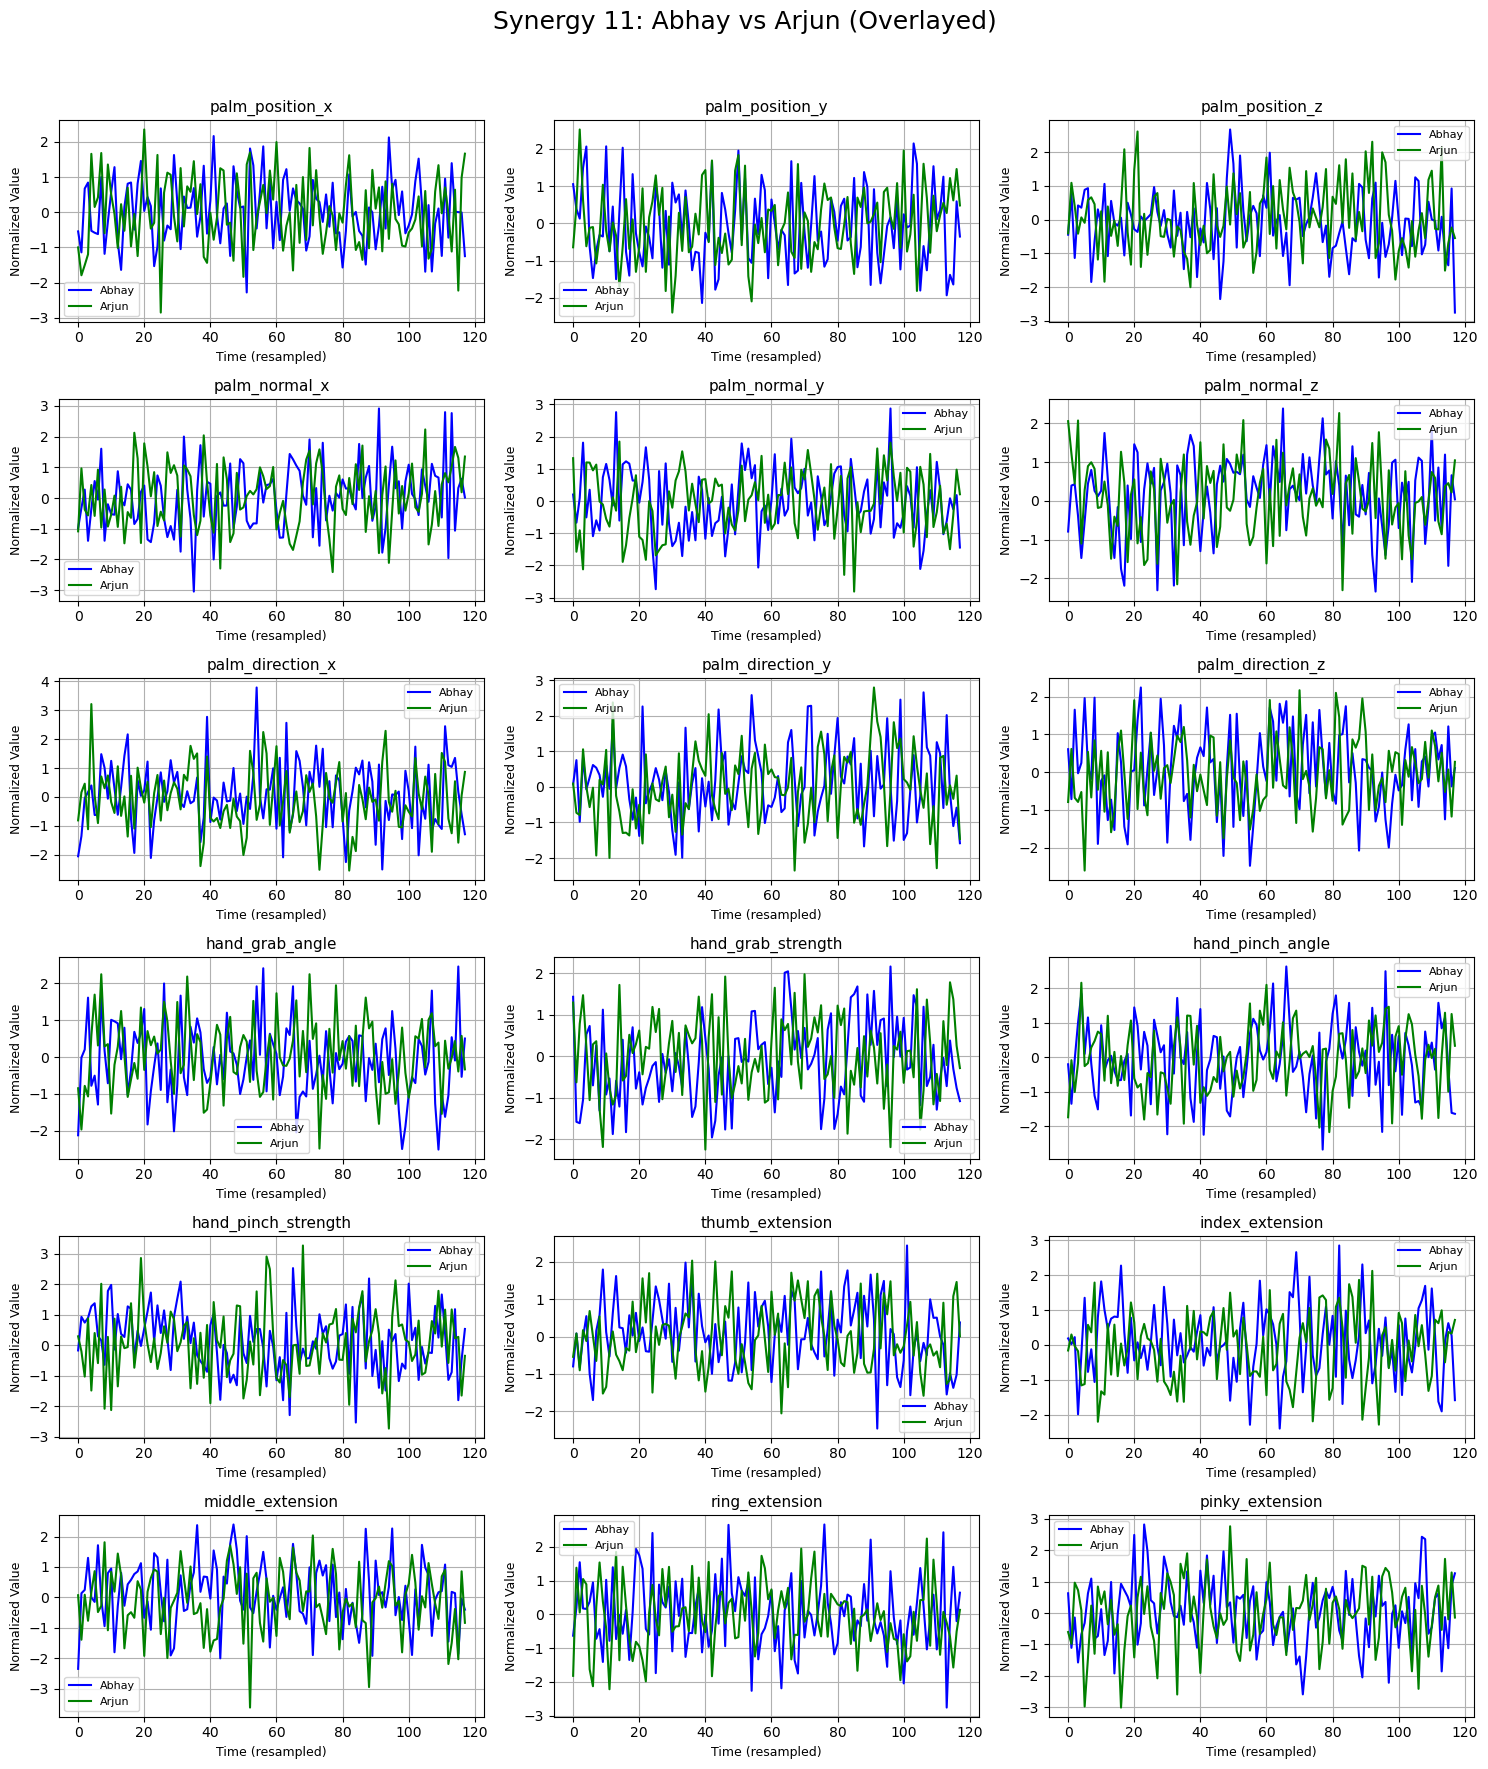

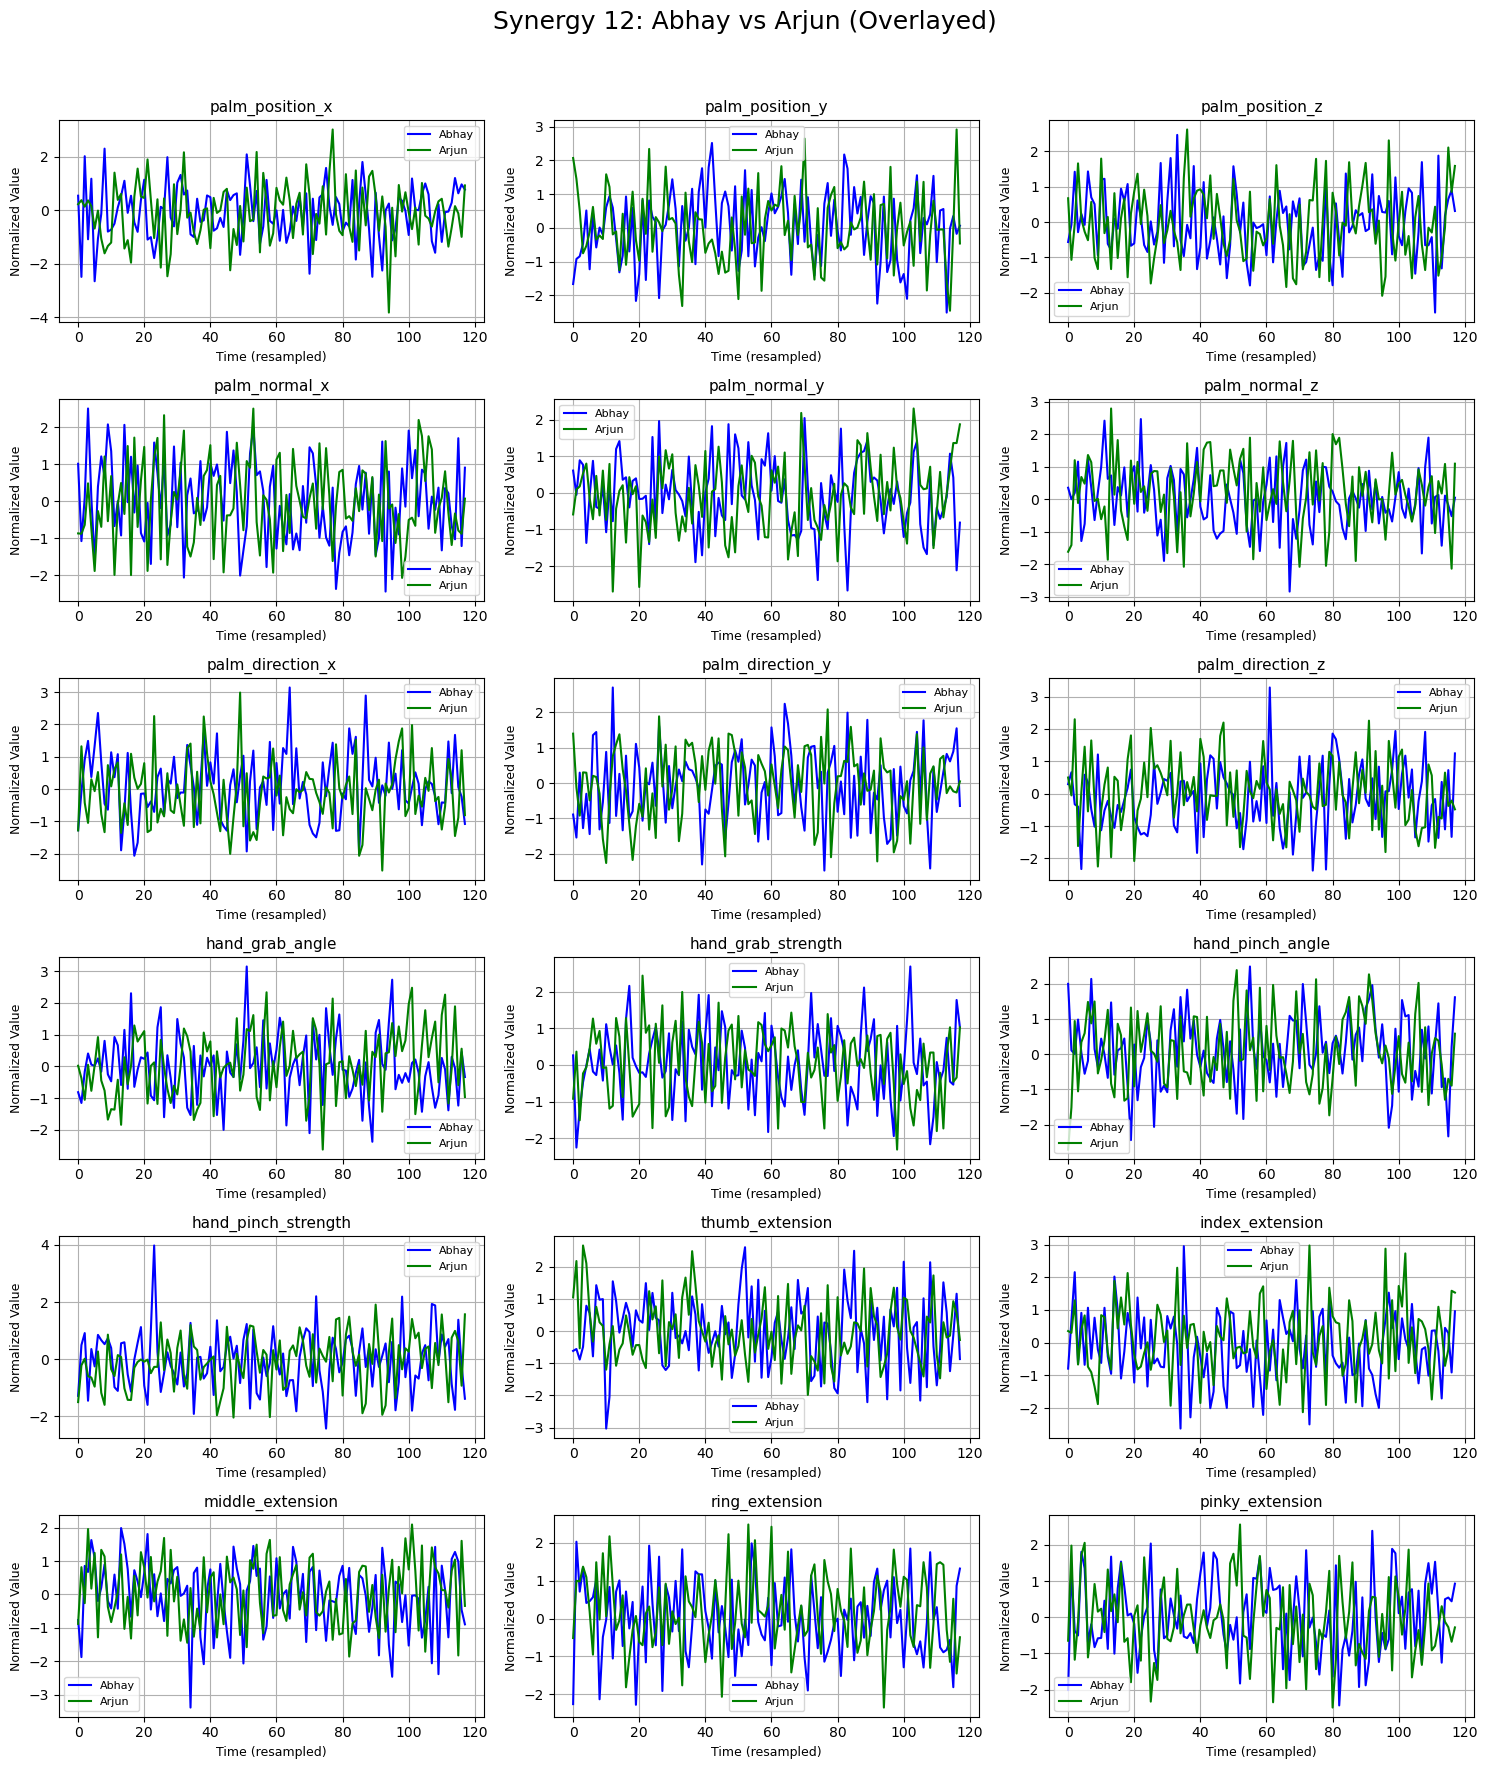

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# === Config ===
resample_length = 118  # number of time steps per joint
num_joints = 18
joint_labels = [
    'palm_position_x', 'palm_position_y', 'palm_position_z',
    'palm_normal_x', 'palm_normal_y', 'palm_normal_z',
    'palm_direction_x', 'palm_direction_y', 'palm_direction_z',
    'hand_grab_angle', 'hand_grab_strength',
    'hand_pinch_angle', 'hand_pinch_strength',
    'thumb_extension', 'index_extension', 'middle_extension',
    'ring_extension', 'pinky_extension'
]

# Synergies to plot (0-based index)
synergies_to_plot = [0, 1, 2, 8, 9, 10, 11]  # Synergies 1–3 and 9–12

def plot_synergy_overlay_per_joint(synergy_indices, abhay_vecs, arjun_vecs):
    for idx in synergy_indices:
        num_rows = int(np.ceil(num_joints / 3))  # 3 plots per row
        fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 3))
        fig.suptitle(f"Synergy {idx + 1}: Abhay vs Arjun (Overlayed)", fontsize=18)

        for j in range(num_joints):
            row = j // 3
            col = j % 3

            start = j * resample_length
            end = (j + 1) * resample_length

            ax = axes[row, col]
            try:
                x = np.arange(resample_length)
                ax.plot(x, abhay_vecs.iloc[idx, start:end], label="Abhay", color="blue")
                ax.plot(x, arjun_vecs.iloc[idx, start:end], label="Arjun", color="green")

            except IndexError:
                ax.text(0.5, 0.5, "Index Error", ha="center", va="center")
                continue

            ax.set_title(joint_labels[j], fontsize=11)
            ax.set_xlabel("Time (resampled)", fontsize=9)
            ax.set_ylabel("Normalized Value", fontsize=9)
            ax.legend(fontsize=8)
            ax.grid(True)

        # Hide unused axes
        total_plots = num_rows * 3
        for k in range(num_joints, total_plots):
            row, col = divmod(k, 3)
            axes[row, col].axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

# === Run plotting ===
plot_synergy_overlay_per_joint(synergies_to_plot, eigenvectors_abhay, eigenvectors_arjun)


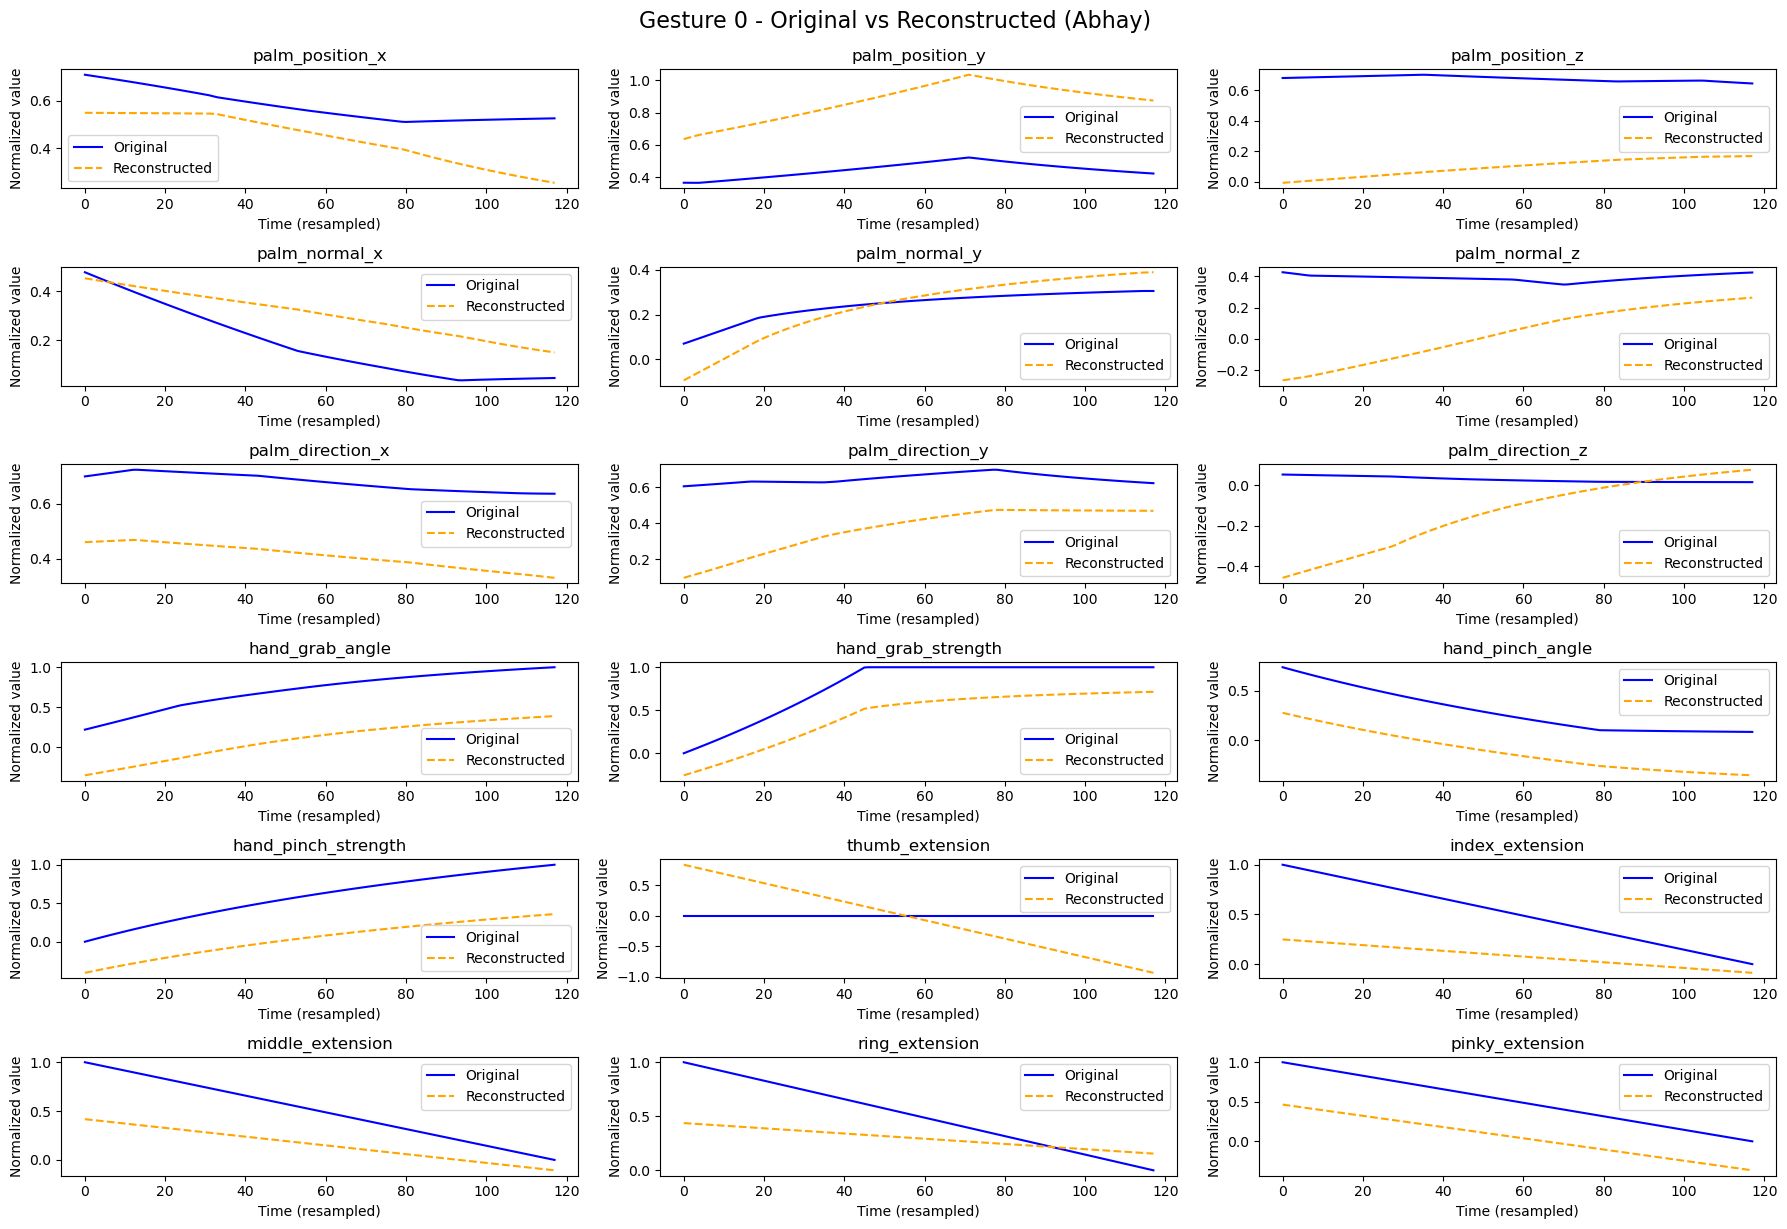

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# === INPUTS REQUIRED ===
# train_abhay: (140, 2124) normalized training DataFrame
# test_abhay: (60, 2124) normalized testing DataFrame
# These should already be normalized before this step

# === PCA Fit on Normalized Train ===
pca = PCA()
pca.fit(train_abhay)

# === Project and Reconstruct Test Data ===
scores = pca.transform(test_abhay)
reconstructed = pd.DataFrame(pca.inverse_transform(scores))

# === Select Gesture Index from Test Set ===
gesture_index = 0  # You can change this from 0–59

# === Reshape Row into (joints x time) Matrix ===
num_joints = 18
resample_len = 118

original_row = test_abhay.iloc[gesture_index].to_numpy().reshape(num_joints, resample_len)
reconstructed_row = reconstructed.iloc[gesture_index].to_numpy().reshape(num_joints, resample_len)

# === Plotting ===
joint_labels = [
    'palm_position_x', 'palm_position_y', 'palm_position_z',
    'palm_normal_x', 'palm_normal_y', 'palm_normal_z',
    'palm_direction_x', 'palm_direction_y', 'palm_direction_z',
    'hand_grab_angle', 'hand_grab_strength', 'hand_pinch_angle', 'hand_pinch_strength',
    'thumb_extension', 'index_extension', 'middle_extension', 'ring_extension', 'pinky_extension'
]

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(16, 12))
axes = axes.flatten()

for i in range(num_joints):
    ax = axes[i]
    ax.plot(original_row[i], label='Original', linewidth=2)
    ax.plot(reconstructed_row[i], label='Reconstructed', linestyle='--')
    ax.set_title(joint_labels[i])
    ax.set_xlabel("Time (resampled)")
    ax.set_ylabel("Normalized Value")
    ax.grid(True)
    ax.legend(loc='upper right')

# Clean layout
plt.tight_layout()
plt.suptitle("Abhay - Original vs Reconstructed Gesture (Normalized)", fontsize=18, y=1.02)
plt.show()
